In [9]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
models_dir = os.path.join(project_root,"models")

In [3]:
plt.style.use("default")
plt.rcParams["figure.figsize"]=(8,5)

PCA_N_PATH = os.path.join(project_root,"creditcard_pca_{}components.csv".format(
    max(10,0)
))

pca_files = [f for f in os.listdir(os.path.join(project_root,"data","processed")) if f.startswith("creditcard_pca_") and f.endswith(".csv")]

if pca_files:
    PCA_N_PATH = os.path.join(project_root, "data", "processed", pca_files[0])
    print("Using PCA file:",PCA_N_PATH)
    df=pd.read_csv(PCA_N_PATH)
    y=df["Class"].values
    X=df.drop(columns=["Class"]).values
else:
    SCALED_PATH = os.path.join(project_root,"data","processed","creditcard_sampled_scaled.csv")
    print("PCA file not found; using scaled data:", SCALED_PATH)
    scaled_df = pd.read_csv(SCALED_PATH)
    y=scaled_df["Class"].values
    X=scaled_df.drop(columns=["Class"]).values

print("X shape:",X.shape, "y shape:",y.shape)

Using PCA file: u:\ML\ml2-unsupervised-creditcard-fraud\data\processed\creditcard_pca_19components.csv
X shape: (20492, 19) y shape: (20492,)


In [4]:
def evaluate_kmeans(X_input, y_true, k_range=range(2,9)):
    results = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X_input)

        sil = silhouette_score(X_input, labels)
        dbi = davies_bouldin_score(X_input, labels)
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
        inertia = km.inertia_

        results.append({
            "k":k,
            "inertia":inertia,
            "silhouette":sil,
            "davies_bouldin":dbi,
            "ARI":ari,
            "NMI":nmi
        })

    return pd.DataFrame(results)

In [5]:
k_range = range(2,9)
results = evaluate_kmeans(X, y, k_range=k_range)
results.style.format({"inertia":"{:.0f}","silhouette":"{:.4f}", "davies_bouldin":"{:.4f}","ARI":"{:.4f}","NMI":"{:.4f}"})

,k,inertia,silhouette,davies_bouldin,ARI,NMI
0,2,410756,0.7743,0.8028,0.5931,0.4832
1,3,386229,0.0957,2.3957,0.0385,0.0969
2,4,372057,0.0923,2.3348,0.0281,0.0750
3,5,358676,0.0872,2.3806,0.0205,0.0624
4,6,349734,0.0808,2.5471,0.0130,0.0531
5,7,329726,0.0844,2.3336,0.0239,0.0970
6,8,330381,0.0929,2.2844,0.0090,0.0443


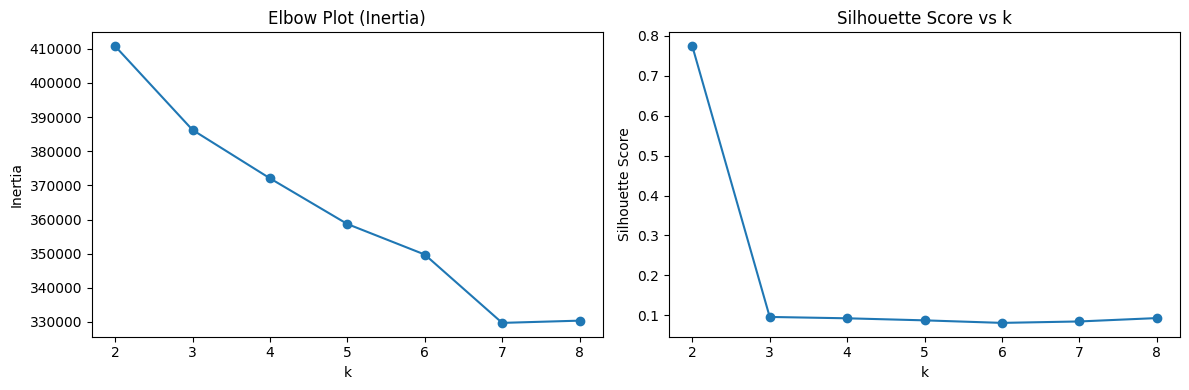

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(results["k"], results["inertia"],marker='o')
plt.title("Elbow Plot (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(results["k"],results["silhouette"],marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

In [10]:
BEST_K = int(results.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("Suggested BEST_K (highest silhouette):", BEST_K)

kmeans_final = KMeans(n_clusters=BEST_K, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X)

Suggested BEST_K (highest silhouette): 2


In [11]:
out_df = pd.DataFrame(X[:,:2], columns=["feat1","feat2"]) if X.shape[1]>=2 else pd.DataFrame(X)
out_df["Class"]=y

kmeans_model_path = os.path.join(models_dir,f"kmeans_k{BEST_K}.joblib")
joblib.dump(kmeans_final, kmeans_model_path)
print("Saved Kmeans model to:",kmeans_model_path)

cluster_df=pd.DataFrame({
    "kmeans_cluster":cluster_labels,
    "Class":y
})

cluster_save_path = os.path.join(project_root,"data","processed",f"creditcard_kmeans_k{BEST_K}.csv")
os.makedirs(os.path.dirname(cluster_save_path),exist_ok=True)
cluster_df.to_csv(cluster_save_path,index=False)

cluster_save_path

Saved Kmeans model to: u:\ML\ml2-unsupervised-creditcard-fraud\models\kmeans_k2.joblib


'u:\\ML\\ml2-unsupervised-creditcard-fraud\\data\\processed\\creditcard_kmeans_k2.csv'

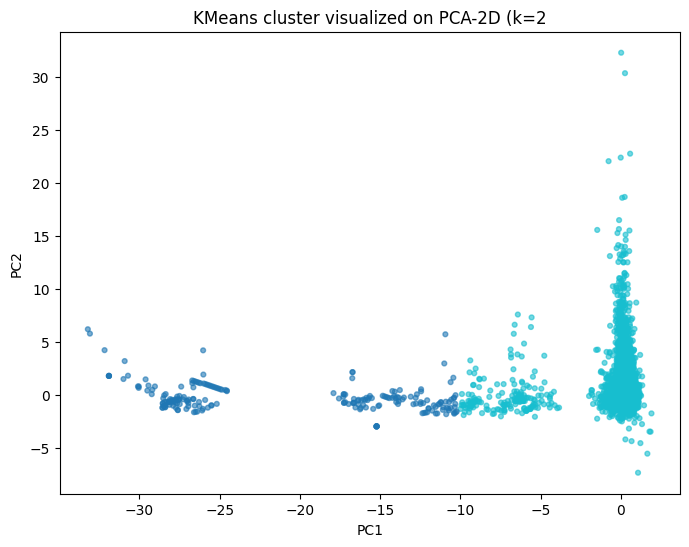

In [12]:
pca2d_path = os.path.join(project_root,"data","processed","creditcard_pca2d.csv")
if "PC1" in pd.read_csv(pca2d_path).columns:
    p2=pd.read_csv(pca2d_path)
    plt.figure(figsize=(8,6))
    plt.scatter(p2["PC1"],p2["PC2"], c=cluster_labels, cmap="tab10",s=12, alpha=0.6)
    plt.title(f"KMeans cluster visualized on PCA-2D (k={BEST_K}")
    plt.xlabel("PC1");plt.ylabel("PC2")
    plt.show()
else:
    plt.figure(figsize=(8,6))
    plt.scatter(out_df["feat1"],out_df["feat2"],c=cluster_labels, cmap="tab10", s=12, alpha=0.6)
    plt.title(f"Kmeans clusters (first two features) (k={BEST_K})")
    plt.show()

In [13]:
ct = pd.crosstab(cluster_df["kmeans_cluster"],cluster_df["Class"], margins=True)
print("\nCluster vs True Cluster (counts):\n",ct)


Cluster vs True Cluster (counts):
 Class               0    1    All
kmeans_cluster                   
0                   1  215    216
1               19999  277  20276
All             20000  492  20492
